### Imports

In [9]:
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None
exp_path = Path.cwd().resolve() # path to the experiment folder

print(f"Repo Path: {repo_path}")
print(f"Experiment Path: {exp_path}")


Repo Path: /home/benet/tfg
Experiment Path: /home/benet/tfg/model_from_scratch


In [10]:
#Libraries
import yaml
import math
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import (
    Dataset,
    DataLoader
)
from tqdm import tqdm
import torchvision
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    ToTensor,
    Normalize,
    InterpolationMode,
)
import wandb
import datasets, diffusers
from diffusers import (
    UNet2DModel,
    DDPMScheduler,
)

from diffusers import DDPMPipeline
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
import logging
from accelerate.logging import get_logger
from accelerate import Accelerator

from PIL import Image
from matplotlib import pyplot as plt

In [11]:
# Check the diffusers version
check_min_version("0.15.0.dev0")

# set the logger
logger = get_logger(__name__, log_level="INFO") # allow from info level and above


### 0. General setups

In [12]:
### 0. General setups
# load the config file
config_path = exp_path / 'config.yaml'
with open('config.yaml') as file: # expects the config file to be in the same directory
    config = yaml.load(file, Loader=yaml.FullLoader)

# define logging directory
pipeline_dir = repo_path / config['saving']['local']['outputs_dir'] / config['saving']['local']['pipeline_name']
logging_dir = pipeline_dir / config['logging']['dir_name']

# start the accelerator
accelerator = Accelerator(
    gradient_accumulation_steps=config['training']['gradient_accumulation']['steps'],
    mixed_precision=config['training']['mixed_precision']['type'],
    log_with=config['logging']['logger_name']  # Keep this if you're using `log_with`
)


# define basic logging configuration
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s", # format of the log message. # name is the logger name.
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)


### 1. Dataset loading and preprocessing

In [13]:
# Dataset loading
data_dir = repo_path / config['processing']['dataset']
# Custom dataset class for .png
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith(".png")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return {"images": image}

preprocess = Compose(
    [
        Resize(config['processing']['resolution'], interpolation= InterpolationMode.BILINEAR), #getattr(InterpolationMode, config['processing']['interpolation'])),  # Smaller edge is resized to 256 preserving aspect ratio
        CenterCrop(config['processing']['resolution']),  # Center crop to the desired squared resolution
        #RandomHorizontalFlip(),  # Horizontal flip may not be a good idea if we want generation only one laterality
        ToTensor(),  # Convert to PyTorch tensor
        Normalize(mean=[0.5], std=[0.5]),  # Map to (-1, 1) as a way to make data more similar to a Gaussian distribution
    ]
)

# Create dataset with the defined transformations
dataset = CustomDataset(data_dir, transform=preprocess)
logger.info(f"Dataset loaded with {len(dataset)} images") # show info about the dataset
# Create the dataloader
train_dataloader = DataLoader(
    dataset, batch_size=config['processing']['batch_size'], num_workers= config['processing']['num_workers'], shuffle=True
)

02/25/2025 12:36:12 - INFO - __main__ -   Dataset loaded with 570 images


torch.Size([32, 1, 128, 128])


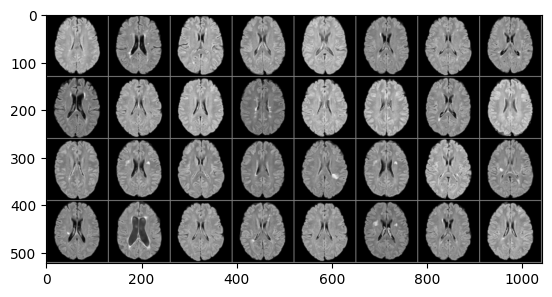

In [14]:
# show the first batch of images
images = next(iter(train_dataloader))["images"]
print(images.shape)
plt.imshow(torchvision.utils.make_grid(images)[0], cmap='gray')

### 2. Model definition

In [7]:
model = UNet2DModel(
    sample_size=config['processing']['resolution'],  # the target image resolution
    in_channels=config['model']['in_channels'],  # the number of input channels, 3 for RGB images
    out_channels=config['model']['out_channels'],  # the number of output channels
    layers_per_block=config['model']['layers_per_block'],  # how many ResNet layers to use per UNet block
    block_out_channels=config['model']['block_out_channels'],  # More channels -> more parameters
    down_block_types= config['model']['down_block_types'],
    up_block_types=config['model']['up_block_types'],
)

### 3. Training

In [8]:
num_epochs = config['training']['num_epochs']
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr= config['training']['optimizer']['learning_rate'], # learning rate of the optimizer
    betas= (config['training']['optimizer']['beta_1'], config['training']['optimizer']['beta_2']), # betas according to the AdamW paper
    weight_decay= config['training']['optimizer']['weight_decay'], # weight decay according to the AdamW paper
    eps= config['training']['optimizer']['eps'] # epsilon according to the AdamW paper
)
lr_scheduler = get_scheduler(
    name= config['training']['lr_scheduler']['name'], # name of the scheduler
    optimizer= optimizer, # optimizer to use
    num_warmup_steps= config['training']['lr_scheduler']['num_warmup_steps'] * config['training']['gradient_accumulation']['steps'],
    num_training_steps= (len(train_dataloader) * num_epochs), #* config['training']['gradient_accumulation']['steps']?
)
noise_scheduler = DDPMScheduler(
    num_train_timesteps=config['training']['noise_scheduler']['num_train_timesteps'],
    beta_schedule=config['training']['noise_scheduler']['beta_schedule'],
)

# prepare with the accelerator
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, lr_scheduler
)
# init tracker (wand or TB)
if accelerator.is_main_process:
    run = os.path.split(__file__)[-1].split(".")[0] # get the name of the script
    accelerator.init_trackers(project_name=run) # intialize a run for all trackers
    wandb.save(str(config_path)) if config['logging']['logger_name'] == 'wandb' else None # save the config file in the wandb run
# global trackers
total_batch_size = config['processing']['batch_size'] * accelerator.num_processes * config['training']['gradient_accumulation']['steps'] # considering accumulated and distributed training
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / config['training']['gradient_accumulation']['steps']) # take into account the gradient accumulation (divide)
max_train_steps = num_epochs * num_update_steps_per_epoch # total number of training steps

logger.info('The training is starting...\n')
logger.info(f'The number of examples is: {len(dataset)}\n')
logger.info(f'The number of epochs is: {num_epochs}\n')
logger.info(f'The number of batches is: {len(train_dataloader)}\n')
logger.info(f'The batch size is: {config["processing"]["batch_size"]}\n')
logger.info(f'The number of update steps per epoch is: {num_update_steps_per_epoch}\n')
logger.info(f'The gradient accumulation steps is: {config["training"]["gradient_accumulation"]["steps"]}\n')
logger.info(f'The total batch size (accumulated, multiprocess) is: {total_batch_size}\n')
logger.info(f'Total optimization steps: {max_train_steps}\n')

# global variables (mainly useful for checkpointing)
global_step = 0

#### Training loop
# Loop over the epochs
for epoch in range(num_epochs):
    model.train()
    train_loss = [] # accumulated loss list
    pbar = tqdm(total=num_update_steps_per_epoch)
    pbar.set_description(f"Epoch {epoch}")
    for batch in train_dataloader: # Loop over the batches
        with accelerator.accumulate(model):
            noise = torch.randn_like(batch) # Sample noise to add to the images and also send it to device(2nd thing in device)
            bs = batch.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint( #create bs random integers from init=0 to end=timesteps, and send them to device (3rd thing in device)
                low= 0,
                high= noise_scheduler.num_train_timesteps,
                size= (bs,),
                device=batch.device ,
            ).long() #int64
            # Forward diffusion process: add noise to the clean images according to the noise magnitude at each timestep
            noisy_images = noise_scheduler.add_noise(batch, noise, timesteps)
            # Get the model prediction, #### This part changes according to the prediction type (e.g. epsilon, sample, etc.)
            noise_pred = model(noisy_images, timesteps).sample # sample tensor
            # Calculate the loss
            loss = F.mse_loss(noise_pred.float(), noise.float())
            # Gather the losses across all processes for logging (if we use distributed training).
            avg_loss = accelerator.gather(loss.repeat(config['processing']['batch_size'])).mean()
            # append the loss to the train loss
            train_loss.append(avg_loss.item())
            
            # Backpropagate the loss
            accelerator.backward(loss) #loss is used as a gradient, coming from the accumulation of the gradients of the loss function
            if accelerator.sync_gradients: # gradient clipping
                accelerator.clip_grad_norm_(model.parameters(), config['training']['gradient_clip']['max_norm'])
            # Update
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        
        # updates and checkpoint saving happens only if the gradients are synced
        if accelerator.sync_gradients:
            # Update the progress bar
            pbar.update(1)
            global_step += 1
            # take the mean of the accumulated loss
            train_loss = np.mean(train_loss)
            accelerator.log({"loss": train_loss, "log-loss": np.log(train_loss)}, step=global_step) #accumulated loss
            train_loss = [] # reset the train for next accumulation
            # Save the checkpoint
            if global_step % config['saving']['local']['checkpoint_frequency'] == 0: # if saving time
                if accelerator.is_main_process: # only if in main process
                    save_path = pipeline_dir / f"checkpoint-{global_step}" # create the path
                    accelerator.save_state(save_path) # save the state
                    logger.info(f"Saving checkpoint to {save_path}") # let the user know
        # step logging
        logs = {"step_loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        accelerator.log(values=logs, step=global_step)
        pbar.set_postfix(**logs)
    # Close the progress bar at the end of the epoch
    pbar.close()
    accelerator.wait_for_everyone() # wait for all processes to finish before saving the model


NameError: name '__file__' is not defined